In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [136]:
df_SPX = pd.read_csv("data/SPX.txt", sep="\t", header=None, names=["date", "price"])
df_SPX["price"] = df_SPX["price"].replace({',' : "."},regex=True).astype(float)

df_USGG2YR = pd.read_csv("data/USGG2YR.txt", sep="\t", header=None, names=["date", "price"])
df_USGG2YR["price"] = df_USGG2YR["price"].replace({',' : "."},regex=True).astype(float)

df_VIX = pd.read_csv("data/VIX.txt", sep="\t", header=None, names=["date", "price"])
df_VIX["price"] = df_VIX["price"].replace({',' : "."},regex=True).astype(float)

In [137]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    plt.clf()
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

In [138]:
data_window_len = 10

def extract_window_data(df):
    window_data = []
    for idx in range(len(df) - data_window_len):
        tmp = df[idx: (idx + data_window_len)].copy()
        tmp = tmp["price"] / tmp["price"].iloc[0] - 1
        window_data.append(tmp.values)
    return np.array(window_data)

def create_data(df):
    train_data = df.iloc[0:939]
    test_data = df.iloc[939:]

    X_train = extract_window_data(train_data)
    X_test = extract_window_data(test_data)

    y_train = train_data["price"][data_window_len:].values
    y_test = test_data["price"][data_window_len:].values

    y_train = y_train / train_data["price"][:-data_window_len].values - 1
    y_test = y_test / test_data["price"][:-data_window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

train_SPX, test_SPX, X_train_SPX, X_test_SPX, y_train_SPX, y_test_SPX = create_data(df_SPX)
train_USGG2YR, test_USGG2YR, X_train_USGG2YR, X_test_USGG2YR, y_train_USGG2YR, y_test_USGG2YR = create_data(df_USGG2YR)
train_VIX, test_VIX, X_train_VIX, X_test_VIX, y_train_VIX, y_test_VIX = create_data(df_VIX)

In [139]:
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model

def create_model():
    model = keras.Sequential()
    model.add(LSTM(120, input_shape=(10, 1)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer="adam", metrics=['accuracy'])
    return model

## On crée un modele par indice
model_SPX = create_model()
model_USGG2YR = create_model()
model_VIX = create_model()

In [140]:
#training models
model_SPX.fit(X_train_SPX, y_train_SPX, batch_size=16, verbose=0, epochs=10, shuffle=False)
model_USGG2YR.fit(X_train_USGG2YR, y_train_USGG2YR, batch_size=16, verbose=0, epochs=10, shuffle=False)
model_VIX.fit(X_train_VIX, y_train_VIX, batch_size=16, verbose=0, epochs=10, shuffle=False)

<Figure size 432x288 with 0 Axes>

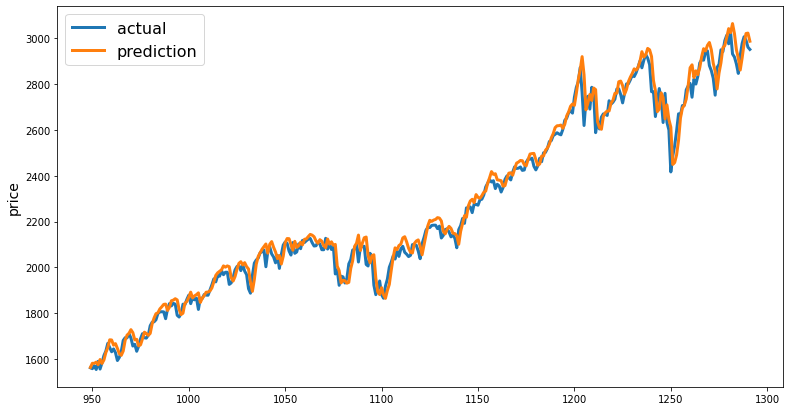

<Figure size 432x288 with 0 Axes>

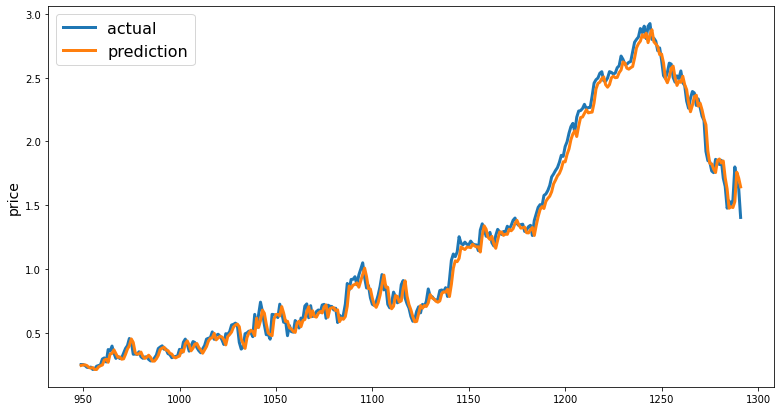

<Figure size 432x288 with 0 Axes>

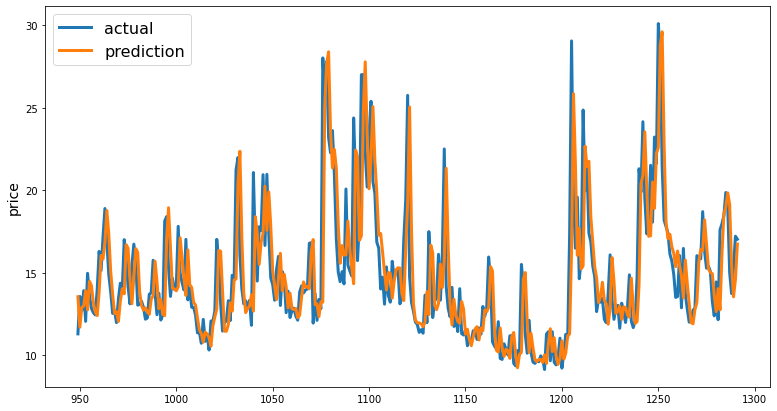

In [141]:
targets_SPX = test_SPX["price"][10:]
preds_SPX = model_SPX.predict(X_test_SPX).squeeze()
preds_SPX = test_SPX["price"].values[:-10] * (preds_SPX + 1)
preds_SPX = pd.Series(index=targets_SPX.index, data=preds_SPX)
line_plot(targets_SPX, preds_SPX, 'actual', 'prediction', lw=3)
plt.show()

targets_USGG2YR = test_USGG2YR["price"][10:]
preds_USGG2YR = model_USGG2YR.predict(X_test_USGG2YR).squeeze()
preds_USGG2YR = test_USGG2YR["price"].values[:-10] * (preds_USGG2YR + 1)
preds_USGG2YR = pd.Series(index=targets_USGG2YR.index, data=preds_USGG2YR)
line_plot(targets_USGG2YR, preds_USGG2YR, 'actual', 'prediction', lw=3)
plt.show()

targets_VIX = test_VIX["price"][10:]
preds_VIX = model_VIX.predict(X_test_VIX).squeeze()
preds_VIX = test_VIX["price"].values[:-10] * (preds_VIX + 1)
preds_VIX = pd.Series(index=targets_VIX.index, data=preds_VIX)
line_plot(targets_VIX, preds_VIX, 'actual', 'prediction', lw=3)
plt.show()

In [145]:
## Use model price prediction as vector 1/0 and sum for trading

def generate_vector(preds, test):
    direction = []
    for i in range(len(preds)):
        pred = preds.iloc[i].round(2)
        prev_price = test.iloc[9 + i]["price"]
        if pred > prev_price:
            direction.append(1)
        else:
            direction.append(0)
        
    return direction

direction_SPX = generate_vector(preds_SPX, test_SPX)
direction_USGG2YR = generate_vector(preds_USGG2YR, test_USGG2YR)
direction_VIX = generate_vector(preds_SPX, test_VIX)


def trading_model(test_VIX, direction_SPX, direction_USGG2YR, direction_VIX):
    gains = 0

    for i in range(9, len(preds_VIX)-1):
            sum_direction = direction_SPX[i-9] + direction_USGG2YR[i-9] + direction_VIX[i-9]      
            prev_value = test_VIX.iloc[i]["price"]
            value = test_VIX.iloc[i+1]["price"]

            if sum_direction > 1:
                gains += value - prev_value
            else:
                gains += prev_value - value
                
    return gains


def trading_random(test_VIX):
    gains = 0
    for i in range(9, len(preds_VIX)-1):
        prev_value = test_VIX.iloc[i]["price"]
        value = test_VIX.iloc[i+1]["price"]
        choice = random.randint(0, 1)
        if choice == 1:
            gains += value - prev_value
        else:
            gains += prev_value - value
            
    return gains
    

gain_algo = trading_model(test_VIX, direction_SPX, direction_USGG2YR, direction_VIX)
gain_random = trading_random(test_VIX)
print(gain_algo, gain_random)

39.049999999999976 -24.130000000000006


| Gain Model  | Gain Random         |
| :---------------: |:---------------:|
| 39.04 |   -24.13  |